In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
plt.style.use('seaborn')
sns.set(font_scale=2)

In [2]:
sensor_df = pd.read_csv('./data/sensor.raw', names=('date', 'indicator'), parse_dates = ['date'])
cont_df = pd.read_csv('./data/cont.raw', names=('indicator', 'counter_', 'date'), parse_dates = ['date'])

In [3]:
MIN_DATE = min(sensor_df.date.min(), cont_df.date.min()).replace(hour=0, minute=0, second=0, microsecond=0)

In [4]:
# Отрежем все нечисленные символы

reg_expr = r'\d+'
reg_expr_compiled = re.compile(reg_expr)
sensor_df['indicator'] = sensor_df.indicator.apply(lambda x: re.findall(reg_expr_compiled, x)[0])
sensor_df['indicator'] = pd.to_numeric(sensor_df.indicator)

In [5]:
counter_df = pd.DataFrame()
counter_df[['indicator', 'date']] = cont_df[['counter_', 'date']].copy()

sensor_df['Датчик'] = 'sensor'
cont_df['Датчик'] = 'cont'
counter_df['Датчик'] = 'счетчик остановок'

In [6]:
df = pd.concat([sensor_df, cont_df[['indicator', 'date', 'Датчик']], counter_df], axis=0)
df = df.reset_index()
df['hours_'] = (df.date - MIN_DATE).dt.seconds / 3600

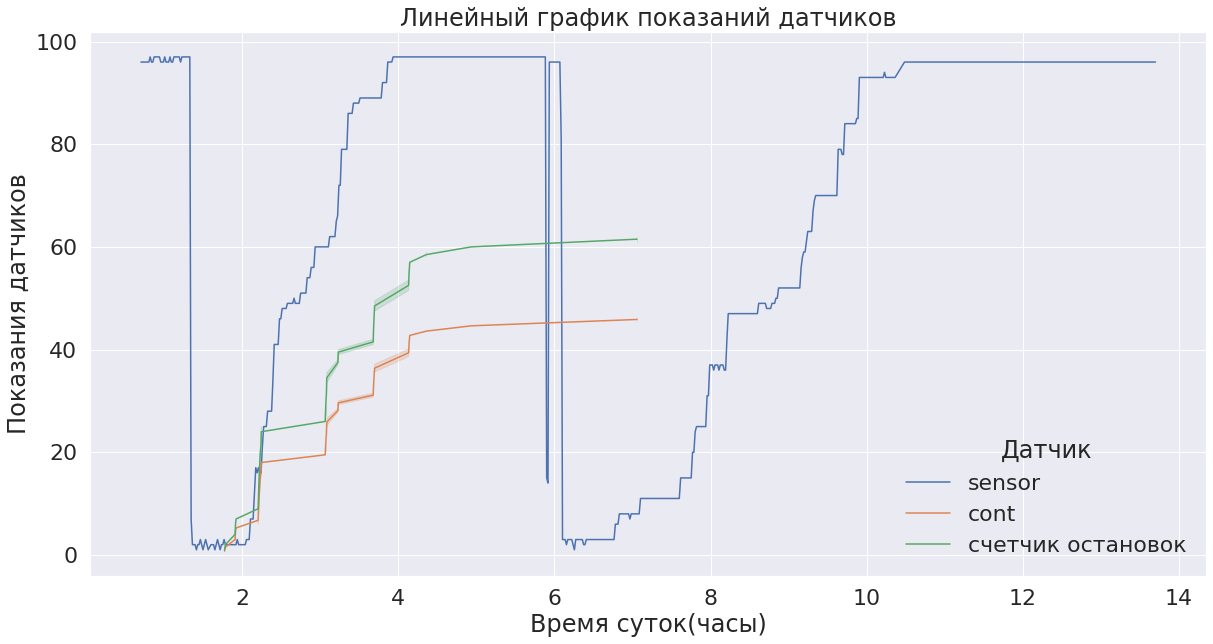

In [7]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(data=df, x='hours_', y='indicator', hue='Датчик')
ax.set_title('Линейный график показаний датчиков')
ax.set_ylabel('Показания датчиков')
ax.set_xlabel('Время суток(часы)')
#plt.savefig('./data/linear.png')
plt.show()

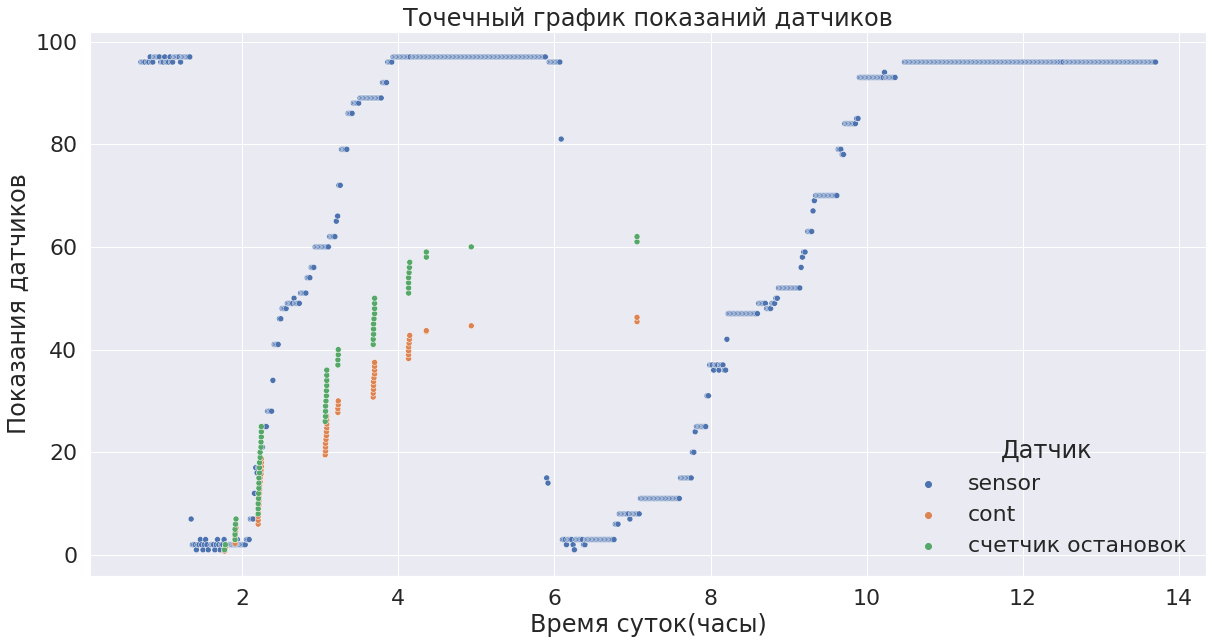

In [8]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x=df.hours_, y=df.indicator, hue=df['Датчик'])
ax.set_title('Точечный график показаний датчиков')
ax.set_ylabel('Показания датчиков')
ax.set_xlabel('Время суток(часы)')
#plt.savefig('./data/scatter.png')
plt.show()

In [9]:
# intervals_df содержит интервалы, где сигнала от датчика cont не было полчаса

intervals_df = pd.DataFrame([df.hours_.min()], columns=['hours_'])
intervals_df = intervals_df.append(pd.DataFrame(df[df['Датчик'] == 'cont']['hours_']))
intervals_df = intervals_df.append(pd.DataFrame([df.hours_.max()], columns=['hours_']))

intervals_df['before'] = intervals_df['hours_'].diff()
intervals_df['after'] = -1 * intervals_df['hours_'].diff(periods=-1)

intervals_df = intervals_df[(intervals_df.before > .5) | (intervals_df.after > .5)]

In [10]:
# concated_df содержит intervals_df + сдвинутый на строку intervals_df для получения зипа с промежутками времени,
# когда не было сигнала от датчика cont

concated_df = pd.concat([intervals_df.shift(), intervals_df], axis=1)
concated_df.columns = (['hours1', 'before1', 'after1', 'hours2', 'before2','after2'])

concated_df = concated_df[(concated_df['after1'] == concated_df['before2']) & concated_df['after1'] > .5]

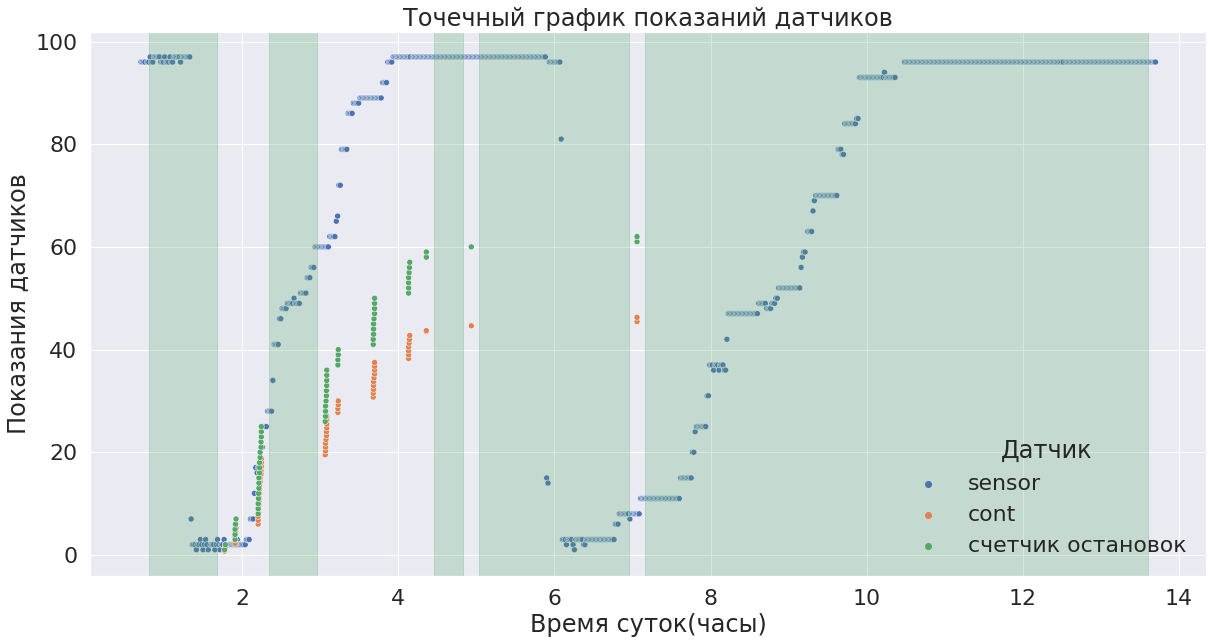

In [13]:
intervals_zip = zip(list(concated_df.hours1), list(concated_df.hours2))

fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(x=df.hours_, y=df.indicator, hue=df['Датчик'])
ax.set_title('Точечный график показаний датчиков')
ax.set_ylabel('Показания датчиков')
ax.set_xlabel('Время суток(часы)')

for i in intervals_zip:
    plt.axvspan(i[0]+.1, i[1]-.1, alpha=.25, color='g')

plt.savefig('./data/scatter.png')

plt.show()